In [13]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from sklearn.ensemble import RandomForestRegressor
#from rfpimp import permutation_importances
from sklearn.metrics import r2_score

import seaborn as sns

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

model_folder = 'model/'

In [38]:
data = pd.read_csv('pr_details_3_dec_4.csv')
data['pr'] = data['arvinds_pr']
data['busy_season'] = data['busy_season'].astype(int)
display(data.shape)
data = data.loc[data['busy_season'] != 1]
data.drop('busy_season',axis=1,inplace=True)
display(data.shape)

(63957, 25)

(61727, 24)

### Creating base Dataframe

In [39]:
month_df = data.groupby(['project_frequency', 'client_rate_type', 'service', 'entry_month']).agg({'ir':'sum', 'pr':'sum', 'project_id':'nunique'}).reset_index()
month_df.columns = ['project_frequency', 'client_rate_type', 'service', 'record_date', 'ir','pr','n_projects']

#calculating target variables
month_df['ir_pr'] = month_df['ir']/month_df['pr']
month_df['pr_project'] = month_df['pr']/month_df['n_projects']



level = 'service + rate'
#level = 'service + frequency'
#level = 'service + rate'
#level = 'rate + frequency'
#level = 'service'
month_df['level'] = ''

count_names = 0

if level.find('service') >= 0:
    month_df['level'] = month_df['level'] + ('_' if count_names >0 else '') + month_df['service'] 
    count_names = 1
if level.find('rate') >= 0:
    month_df['level'] = month_df['level'] + ('_' if count_names >0 else '') + month_df['client_rate_type']
    count_names = 1
if level.find('frequency') >= 0:
    month_df['level'] = month_df['level'] + ('_' if count_names >0 else '') + month_df['project_frequency'] 
    count_names = 1

month_df['level'] = month_df['level'].apply(lambda x: x.replace(' ', ''))

month_df.head()




,project_frequency,client_rate_type,service,record_date,ir,pr,n_projects,ir_pr,pr_project,level
0,One Time,Fixed,CFO,2017-07-01,0.0,8000.0,1,0.0,8000.0,CFO_Fixed
1,One Time,Fixed,CFO,2017-08-01,3500.0,3500.0,1,1.0,3500.0,CFO_Fixed
2,One Time,Fixed,CFO,2017-09-01,2000.0,2000.0,1,1.0,2000.0,CFO_Fixed
3,One Time,Fixed,CFO,2017-11-01,2500.0,2500.0,1,1.0,2500.0,CFO_Fixed
4,One Time,Fixed,CFO,2018-10-01,5000.0,5000.0,1,1.0,5000.0,CFO_Fixed


In [40]:
project_frequency = 'Recurring monthly'
rec_df = data.loc[data.project_frequency == project_frequency]
service_df=pd.DataFrame(rec_df.groupby(['entry_month','service'])['client_rate_hourly'].median()).reset_index()
df = pd.pivot_table(service_df, values = ['client_rate_hourly'], index=['entry_month'], columns = 'service').reset_index()

df.columns = ['entry_month','cfo_price','cpa_price','fpa_price','book_price','tax_price']
for col in df.columns[1:]:
    df[col] = df[col].fillna(df[col].mean())

price_df_recurring = df.copy()
    
# project_frequency = 'One Time'
rec_df = data.loc[data.project_frequency == project_frequency]
service_df=pd.DataFrame(rec_df.groupby(['entry_month','service'])['client_rate_hourly'].median()).reset_index()
df = pd.pivot_table(service_df, values = ['client_rate_hourly'], index=['entry_month'], columns = 'service').reset_index()

df.columns = ['entry_month','cfo_price','cpa_price','fpa_price','book_price','tax_price']
for col in df.columns[1:]:
    df[col] = df[col].fillna(df[col].mean())
price_df_one_time = df.copy()

In [41]:
price_df_one_time.shape

(70, 6)

In [42]:

annual_revenue = pd.DataFrame(data.groupby(['entry_month','annual_revenue'])['pr'].sum()).reset_index()
annual_revenue_temp_1=pd.pivot_table(annual_revenue, values = ['pr'], index=['entry_month'], columns = 'annual_revenue').reset_index()

annual_revenue_temp_1.columns = ['entry_month','0 - 1M pr','10M - 50M pr','1M - 10M pr','50M + pr','No Annual Revenue pr','Pre-revenue pr']
annual_revenue_temp_1.fillna(1,inplace=True)
annual_revenue_temp_1.replace(0.0,1, inplace=True)
annual_revenue_temp_1['total_pr'] = annual_revenue_temp_1['0 - 1M pr'] + annual_revenue_temp_1['10M - 50M pr'] + annual_revenue_temp_1['1M - 10M pr'] + annual_revenue_temp_1['50M + pr'] + annual_revenue_temp_1['No Annual Revenue pr'] + annual_revenue_temp_1['Pre-revenue pr']

annual_revenue_cols = ['total_pr','0 - 1M pr','10M - 50M pr','1M - 10M pr','50M + pr','No Annual Revenue pr','Pre-revenue pr']
annual_revenue_comp = annual_revenue_temp_1[annual_revenue_cols]
annual_revenue_comp = annual_revenue_comp.divide(annual_revenue_comp['total_pr'], axis=0)
base_annual_revenue = 'No Annual Revenue pr'
annual_revenue_cv = annual_revenue_comp.divide(annual_revenue_comp[base_annual_revenue], axis=0)
annual_revenue_cv =np.log(annual_revenue_cv)
annual_revenue_cv.drop('total_pr',axis=1,inplace=True)

annual_revenue_cv['entry_month'] = annual_revenue_temp_1['entry_month']

In [43]:

# #annual_revenue_temp_1=pd.pivot_table(annual_revenue, values = ['salesforce_opportunity_id'], index=['record_date'], columns = 'annual_revenue').reset_index()
# #annual_revenue_temp_1.columns = ['record_date','0 - 1M Opps','10M - 50M opps','1M - 10M opps','50M + opps','No Annual Revenue opps','Pre-revenue opps']
# #annual_revenue_temp_1.fillna(0.1,inplace=True)

# annual_revenue_cols = ['opps_in_current_month','0 - 1M Opps','10M - 50M opps','1M - 10M opps','50M + opps','No Annual Revenue opps','Pre-revenue opps']
# annual_revenue_comp = agg_data_9[annual_revenue_cols]
# annual_revenue_comp = annual_revenue_comp.divide(annual_revenue_comp['opps_in_current_month'], axis=0)
# base_annual_revenue = 'No Annual Revenue opps'
# annual_revenue_cv = annual_revenue_comp.divide(annual_revenue_comp[base_annual_revenue], axis=0)
# annual_revenue_cv =np.log(annual_revenue_cv)
# annual_revenue_cv.drop('opps_in_current_month',axis=1,inplace=True)

In [44]:
raw_input = month_df.loc[(month_df.project_frequency == project_frequency) & (month_df.record_date >= '2018-01-01') & (month_df.record_date <= '2021-04-01')].copy()
func_df = raw_input
one_time_pr_df = func_df.groupby('record_date').agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
one_time_pr_df['pr_project'] = one_time_pr_df['pr']/one_time_pr_df['n_projects']
one_time_pr_df['ir/pr'] = one_time_pr_df['ir']/one_time_pr_df['pr']

one_time_serviceline_df = func_df.groupby(['record_date', 'service']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
one_time_serviceline_df = one_time_serviceline_df.pivot(index='record_date', columns='service', values = 'pr').reset_index()
one_time_serviceline_df = one_time_serviceline_df.fillna(0.1)
one_time_rate_df = func_df.groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
one_time_rate_df = one_time_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()


# one_time_model_df = one_time_pr_df.merge(one_time_serviceline_df, how='inner')
# one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'cfo', 'cpa', 'fpa', 'bkkp', 'tax']
# one_time_model_df.head()
# level_names = ['cfo', 'cpa', 'fpa', 'bkkp', 'tax']
# level_cv = one_time_model_df[level_names]
# level_cv = level_cv.divide(one_time_model_df.pr, axis=0)
# base_level = 'tax'
# level_cv = level_cv.divide(level_cv[base_level], axis=0)
# level_cv = level_cv.drop(base_level, axis=1)
# level_cv = level_cv.applymap(np.log)

one_time_pr_df

,record_date,ir,pr,n_projects,pr_project,ir/pr
0,2018-01-01,131496.320007,170867.916667,266,642.360589,0.769579
1,2018-02-01,139777.220013,201217.566667,299,672.968450,0.694657
2,2018-03-01,163805.674993,220526.816667,338,652.446203,0.742793
3,2018-04-01,131718.880008,216756.750000,362,598.775552,0.607681
4,2018-05-01,145078.240000,215475.050000,385,559.675455,0.673295
5,2018-06-01,154108.930000,247727.416667,384,645.123481,0.622091
6,2018-07-01,157720.640000,249732.083333,400,624.330208,0.631559
7,2018-08-01,160005.160000,250842.650000,420,597.244405,0.637871
8,2018-09-01,147001.770000,265398.333334,439,604.552012,0.553891
9,2018-10-01,186823.680000,255890.391666,468,546.774341,0.730093


### Function for Dataprep

In [45]:
# simulation

def calculate_features(func_df, include_n_projects, include_pr, include_trend, constant_trend = -1):
    
    one_time_pr_df = func_df.groupby('record_date').agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_pr_df['pr_project'] = one_time_pr_df['pr']/one_time_pr_df['n_projects']
    one_time_pr_df['ir/pr'] = one_time_pr_df['ir']/one_time_pr_df['pr']

    one_time_level_df = func_df.groupby(['record_date', 'level']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_level_df = one_time_level_df.pivot(index='record_date', columns='level', values = 'pr').reset_index()
    one_time_level_df = one_time_level_df.fillna(0.1)

    one_time_serviceline_df = func_df.groupby(['record_date', 'service']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_serviceline_df = one_time_serviceline_df.pivot(index='record_date', columns='service', values = 'pr').reset_index()
    one_time_serviceline_df = one_time_serviceline_df.fillna(0.1)
    one_time_rate_df = func_df.groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_rate_df = one_time_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()


    one_time_cfo_rate_df = func_df.loc[(func_df.service == 'CFO')].groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_cfo_rate_df = one_time_cfo_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()
    one_time_cfo_rate_df = one_time_cfo_rate_df.fillna(0.1)


    one_time_cpa_rate_df = func_df.loc[(func_df.service == 'CPA/Accounting Advisory')].groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_cpa_rate_df = one_time_cpa_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()
    one_time_cpa_rate_df = one_time_cpa_rate_df.fillna(0.1)


    one_time_fpa_rate_df = func_df.loc[(func_df.service == 'FP&A')].groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_fpa_rate_df = one_time_fpa_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()
    one_time_fpa_rate_df = one_time_fpa_rate_df.fillna(0.1)


    one_time_bkp_rate_df = func_df.loc[(func_df.service == 'Full Charge Bookkeeping')].groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_bkp_rate_df = one_time_bkp_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()
    one_time_bkp_rate_df = one_time_bkp_rate_df.fillna(0.1)

    one_time_tax_rate_df = func_df.loc[(func_df.service == 'Tax Preparation')].groupby(['record_date', 'client_rate_type']).agg({'ir':'sum', 'pr':'sum', 'n_projects':'sum'}).reset_index()
    one_time_tax_rate_df = one_time_tax_rate_df.pivot(index='record_date', columns='client_rate_type', values = 'pr').reset_index()
    one_time_tax_rate_df = one_time_tax_rate_df.fillna(0.1)


    one_time_model_df = one_time_pr_df.merge(one_time_serviceline_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'cfo', 'cpa', 'fpa', 'bkkp', 'tax']
    one_time_model_df.head()
    level_names = ['cfo', 'cpa', 'fpa', 'bkkp', 'tax']
    level_cv = one_time_model_df[level_names]
    level_cv = level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'tax'
    level_cv = level_cv.divide(level_cv[base_level], axis=0)
    level_cv = level_cv.drop(base_level, axis=1)
    level_cv = level_cv.applymap(np.log)

    # CFO
    one_time_model_df = one_time_pr_df.merge(one_time_cfo_rate_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'cfo_fixed', 'cfo_hourly']
    one_time_model_df.head()
    level_names = ['cfo_fixed', 'cfo_hourly']
    cfo_level_cv = one_time_model_df[level_names]
    cfo_level_cv = cfo_level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'cfo_hourly'
    cfo_level_cv = cfo_level_cv.divide(cfo_level_cv[base_level], axis=0)
    cfo_level_cv = cfo_level_cv.drop(base_level, axis=1)
    cfo_level_cv = cfo_level_cv.applymap(np.log)

    #CPA
    one_time_model_df = one_time_pr_df.merge(one_time_cpa_rate_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'cpa_fixed', 'cpa_hourly']
    one_time_model_df.head()
    level_names = ['cpa_fixed', 'cpa_hourly']
    cpa_level_cv = one_time_model_df[level_names]
    cpa_level_cv = cpa_level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'cpa_hourly'
    cpa_level_cv = cpa_level_cv.divide(cpa_level_cv[base_level], axis=0)
    cpa_level_cv = cpa_level_cv.drop(base_level, axis=1)
    cpa_level_cv = cpa_level_cv.applymap(np.log)

    #FPA
    one_time_model_df = one_time_pr_df.merge(one_time_fpa_rate_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'fpa_fixed', 'fpa_hourly']
    one_time_model_df.head()
    level_names = ['fpa_fixed', 'fpa_hourly']
    fpa_level_cv = one_time_model_df[level_names]
    fpa_level_cv = fpa_level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'fpa_hourly'
    fpa_level_cv = fpa_level_cv.divide(fpa_level_cv[base_level], axis=0)
    fpa_level_cv = fpa_level_cv.drop(base_level, axis=1)
    fpa_level_cv = fpa_level_cv.applymap(np.log)


    #BKKp
    one_time_model_df = one_time_pr_df.merge(one_time_bkp_rate_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'bkkp_fixed', 'bkkp_hourly']
    one_time_model_df.head()
    level_names = ['bkkp_fixed', 'bkkp_hourly']
    bkp_level_cv = one_time_model_df[level_names]
    bkp_level_cv = bkp_level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'bkkp_hourly'
    bkp_level_cv = bkp_level_cv.divide(bkp_level_cv[base_level], axis=0)
    bkp_level_cv = bkp_level_cv.drop(base_level, axis=1)
    bkp_level_cv = bkp_level_cv.applymap(np.log)


    #Tax
    one_time_model_df = one_time_pr_df.merge(one_time_tax_rate_df, how='inner')
    one_time_model_df.columns = ['record_date', 'ir', 'pr', 'n_projects', 'pr_project', 'ir/pr', 'tax_fixed', 'tax_hourly']
    one_time_model_df.head()
    level_names = ['tax_fixed', 'tax_hourly']
    tax_level_cv = one_time_model_df[level_names]
    tax_level_cv = tax_level_cv.divide(one_time_model_df.pr, axis=0)
    base_level = 'tax_hourly'
    tax_level_cv = tax_level_cv.divide(tax_level_cv[base_level], axis=0)
    tax_level_cv = tax_level_cv.drop(base_level, axis=1)
    tax_level_cv = tax_level_cv.applymap(np.log)

    one_time_pr_df = one_time_pr_df.reset_index()

    model_data = pd.concat([level_cv, cfo_level_cv, cpa_level_cv, fpa_level_cv, bkp_level_cv, tax_level_cv], axis = 1)
    if include_pr:
        model_data = pd.concat([model_data, one_time_pr_df['pr']], axis = 1)
    if include_n_projects:
        model_data = pd.concat([model_data, one_time_pr_df['n_projects']], axis = 1)
    if include_trend and constant_trend < 0:
        model_data = pd.concat([model_data, pd.Series(list(range(1,model_data.shape[0]+1)), name='trend')], axis=1)
    elif include_trend:
        model_data = pd.concat([model_data, pd.Series(np.ones(model_data.shape[0])*constant_trend, name='trend')], axis=1)
    x = model_data
    y = one_time_model_df['ir']
    return (x,y)

In [46]:
# raw_input.record_date.nunique()
# x.shape
# price_df_recurring.loc[(price_df_recurring.entry_month >= '2018-01-01') & (price_df_recurring.entry_month <= '2021-07-01')].shape
# x_val

## Recurring Model

MAPE for model: 0.022034614132869227
Test MAPE for model: 0.15448311623497704
                 Generalized Linear Model Regression Results                  
Dep. Variable:                     ir   No. Observations:                   42
Model:                            GLM   Df Residuals:                       21
Model Family:                Gaussian   Df Model:                           20
Link Function:                    log   Scale:                      1.9604e+08
Method:                          IRLS   Log-Likelihood:                -450.07
Date:                Wed, 08 Dec 2021   Deviance:                   4.1168e+09
Time:                        16:23:15   Pearson chi2:                 4.12e+09
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------

C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


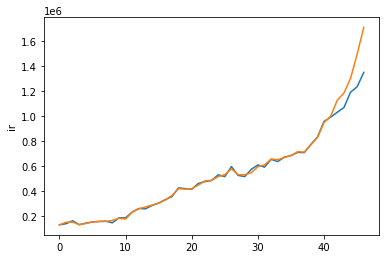

In [47]:
# Model based on FSV
project_frequency = 'Recurring monthly'
level_model = False
include_trend = False
include_pr = True
include_n_projects = False
model_dict = {1:'Random Forest', 2:'Regression', 3: 'XGB'}
selected_model = 2
model_name = (project_frequency + '_' + model_dict[selected_model]).lower().replace(' ','_')

#calculate_features(base_data_final, include_n_projects, include_pr, include_trend7)

raw_input = month_df.loc[(month_df.project_frequency == project_frequency) & (month_df.record_date >= '2018-01-01') & (month_df.record_date <= '2021-11-01')].copy()
x, y = calculate_features(raw_input, include_n_projects, include_pr, include_trend)

x_price = price_df_recurring.loc[(price_df_recurring.entry_month >= '2018-01-01') & (price_df_recurring.entry_month <= '2021-11-01')].drop('entry_month', axis=1).reset_index(drop=True)
annual_revenue_cv_ = annual_revenue_cv.loc[(annual_revenue_cv.entry_month >= '2018-01-01') & (annual_revenue_cv.entry_month <= '2021-11-01')].drop('entry_month', axis=1).reset_index(drop=True)
x = pd.concat([x, x_price, annual_revenue_cv_], axis=1)

train_months = 42
x_train, y_train = x[0:train_months], y[0:train_months]
x_val, y_val = x[train_months:], y[train_months:]

model_features = x.columns
formula = ' + '.join(list(model_features))
formula = 'y_train ~ ' + formula 

x = sm.add_constant(x)
x_train = sm.add_constant(x_train)
x_val = sm.add_constant(x_val, has_constant='add')
# x_val['const'] = 1
model = sm.GLM(y_train, x_train, family = sm.families.Gaussian(link=sm.families.links.log())).fit()
print(f'MAPE for model: {mean_absolute_percentage_error(y_train, model.predict(x_train))}')
model.predict(x_val)
print(f'Test MAPE for model: {mean_absolute_percentage_error(y_val, model.predict(x_val))}')
print(model.summary())
sns.lineplot(x = range(0,len(y)), y = y)
sns.lineplot(x = range(0,len(y)), y = model.predict(x))

pickle.dump(model, open(f'{model_folder}{model_name}_model.sav', 'wb')) 

In [48]:
model.predict(x_val)

42    1.128617e+06
43    1.185027e+06
44    1.302028e+06
45    1.496111e+06
46    1.711568e+06
dtype: float64

In [49]:

x_val

,const,cfo,cpa,fpa,bkkp,cfo_fixed,cpa_fixed,fpa_fixed,bkkp_fixed,tax_fixed,...,cpa_price,fpa_price,book_price,tax_price,0 - 1M pr,10M - 50M pr,1M - 10M pr,50M + pr,No Annual Revenue pr,Pre-revenue pr
42,1.0,1.874529,2.278279,0.696429,2.562208,0.200443,0.434431,0.295343,0.714755,-0.502274,...,100.0,150.0,60.0,100.0,0.151466,-0.728092,0.554491,-0.790855,0.0,-3.835074
43,1.0,2.146236,2.238242,0.485172,2.570532,0.373328,0.618776,-0.061962,0.675990,-0.485205,...,100.0,150.0,60.0,100.0,0.072301,-0.870333,0.526702,-1.542358,0.0,-3.904817
44,1.0,2.040850,2.046297,0.622688,2.397660,0.437552,0.509624,-0.691003,0.706188,-0.728305,...,110.0,150.0,60.0,100.0,-0.041997,-0.859817,0.402322,-1.983508,0.0,-4.112853
45,1.0,2.151946,2.153706,0.605140,2.481636,0.293571,0.469626,-1.217235,0.814789,-0.656969,...,120.0,150.0,60.0,100.0,0.038236,-0.450799,0.418955,-1.690143,0.0,-4.004226
46,1.0,2.627393,2.505944,0.920820,2.872320,0.322938,0.354259,-1.239871,0.787831,-1.111608,...,120.0,150.0,60.0,100.0,0.005500,-0.984313,0.444408,-2.050891,0.0,-4.170499


## OneTime Model

MAPE for model: 0.14365662344216584
Test MAPE for model: 0.11500167018305618
                                 OLS Regression Results                                
Dep. Variable:                     ir   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.962
Method:                 Least Squares   F-statistic:                              52.17
Date:                Wed, 08 Dec 2021   Prob (F-statistic):                    1.16e-13
Time:                        16:23:21   Log-Likelihood:                         -494.01
No. Observations:                  42   AIC:                                      1030.
Df Residuals:                      21   BIC:                                      1067.
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                           coef    std err 

C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\statsmodels\regression\linear_model.py:1755: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\statsmodels\base\model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\ArvindYekkirala\AppData\Roaming\Python\Python37\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


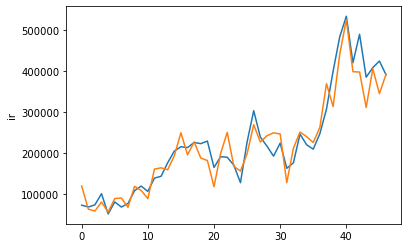

In [50]:
# Model based on FSV
project_frequency = 'One Time'
level_model = False
include_trend = False
include_pr = True
include_n_projects = False
model_dict = {1:'Random Forest', 2:'Regression', 3: 'XGB'}
selected_model = 2
model_name = (project_frequency + '_' + model_dict[selected_model]).lower().replace(' ','_')

#calculate_features(base_data_final, include_n_projects, include_pr, include_trend7)

raw_input = month_df.loc[(month_df.project_frequency == project_frequency) & (month_df.record_date >= '2018-01-01') & (month_df.record_date <= '2021-11-01')].copy()
x, y = calculate_features(raw_input, include_n_projects, include_pr, include_trend)

x_price = price_df_one_time.loc[(price_df_one_time.entry_month >= '2018-01-01') & (price_df_one_time.entry_month <= '2021-11-01')].drop('entry_month', axis=1).reset_index(drop=True)
annual_revenue_cv_ = annual_revenue_cv.loc[(annual_revenue_cv.entry_month >= '2018-01-01') & (annual_revenue_cv.entry_month <= '2021-11-01')].drop('entry_month', axis=1).reset_index(drop=True)
x = pd.concat([x, x_price, annual_revenue_cv_], axis=1)

# x = x[:-3]

train_months = 42
x_train, y_train = x[0:train_months], y[0:train_months]
x_val, y_val = x[train_months:], y[train_months:]

model_features = x.columns
formula = ' + '.join(list(model_features))
formula = 'y_train ~ ' + formula 

x = sm.add_constant(x, has_constant='add')
x_train = sm.add_constant(x_train, has_constant='add')
x_val = sm.add_constant(x_val, has_constant='add')

model = sm.OLS(y_train, x_train, family = sm.families.Gamma(link = sm.families.links.log()), hasconst=False).fit()
print(f'MAPE for model: {mean_absolute_percentage_error(y_train, model.predict(x_train))}')
print(f'Test MAPE for model: {mean_absolute_percentage_error(y_val, model.predict(x_val))}')
print(model.summary())
sns.lineplot(x = range(0,len(y)), y = y)
sns.lineplot(x = range(0,len(y)), y = model.predict(x))

pickle.dump(model, open(f'{model_folder}{model_name}_model.sav', 'wb')) 

In [37]:
y

0      74018.219993
1      69535.100004
2      74790.239996
3     101855.300052
4      52725.080000
5      81868.450000
6      69403.400000
7      78108.400000
8     109418.450000
9     120420.490000
10    107527.800000
11    139884.340000
12    144217.520000
13    177075.980000
14    205582.050000
15    216139.780000
16    213992.190000
17    226534.960000
18    223654.960000
19    229888.440000
20    165698.670000
21    191950.050000
22    190547.470000
23    171174.570000
24    134757.240000
25    258227.470000
26    353023.420000
27    252789.380000
28    220891.400000
29    194511.130000
30    234867.580000
31    170240.180000
32    185043.120000
33    264533.600000
34    222611.520000
35    217234.450000
36    305555.860000
37    514083.270000
38    807594.020000
39    748896.590000
40    643613.530000
41    443120.320000
42    526568.540000
43    482968.440000
44    601445.640000
45    567967.180000
46    512565.690000
Name: ir, dtype: float64